# Participant Exclusion and Replacement Pipeline

1. The counterbalancing.csv contains every json that needs to be sampled for the discrimination and verbal judgement experiment (includes all durations) 
    - The row number for each sequence corresponds to the url fragment used in the variables file uploaded to Mechanical Turk 
    - This file does not change, the variables files is updated to resample sequences that get excluded
2. First need to match up reported participant worker IDs to worker IDs reported in batch data 
    - All data files downloaded from the server need to be matched to a worker ID in batch data
    - Data files that do not have a matched worker ID are moved to a seperate folder and are not analyzed 
3. Participant exclusion criteron are pre-registered on OSF (https://osf.io/28vjd) - if the participant is excluded, the counterbalanced sequence needs to be replaced in the variables file 
4. All participants who have completed need to be excluded from completing future HITs (exclude_workers.csv)

In [59]:
import os
import json 
import pandas as pd 
import numpy as np 
import math
import matplotlib.pyplot as plt

In [60]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [61]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [62]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  271


In [63]:
num_trials = 24

In [64]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [65]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 9


In [66]:
len(pracTries_cleaned_data.subjID.unique())

262

In [67]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [68]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  26
Number of participants that did not respond for 4 or more trials: 4
Number of participants left:  236


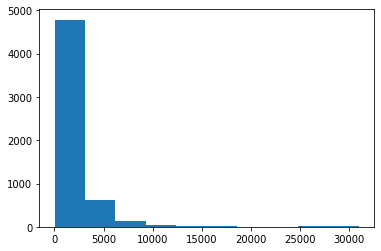

In [69]:
plt.hist(list(Accuracy_cleaned_data['RT']))
plt.show()

In [70]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [71]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 5000], num_trials)


236
236


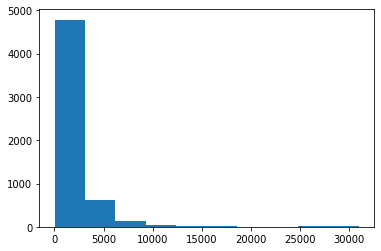

In [72]:
plt.hist(trialRTs_distribution)
plt.show()

In [73]:
all_subjIDs = RT_cleaned_data.subjID.unique()
dist = []
for subj in all_subjIDs:
    count = 0
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID'] == subj]
    dist.append(len(subj_df))
#     print(len(subj_df))

In [74]:
len([d for d in dist if d >11])

228

In [75]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [76]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [77]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 22)

Number of Participants with >= 10% trials removed:  45
Number of participants left:  191


In [78]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

191

In [79]:
seq_count = {}

incl_subjs = raw_final_data.subjID.unique()

for subj in incl_subjs:
    subjdf = raw_final_data.loc[raw_final_data['subjID'] == subj]
    subj_seq = subjdf.sequenceName.unique()[0]
    if subj_seq not in seq_count.keys():
        seq_count[subj_seq] = 1
    else:
        seq_count[subj_seq] += 1
len(seq_count.keys())
seq_count

{'jsons/s22.json': 8,
 'jsons/s13.json': 8,
 'jsons/s14.json': 8,
 'jsons/s3.json': 8,
 'jsons/s19.json': 8,
 'jsons/s7.json': 8,
 'jsons/s2.json': 8,
 'jsons/s1.json': 8,
 'jsons/s10.json': 8,
 'jsons/s12.json': 8,
 'jsons/s23.json': 8,
 'jsons/s9.json': 8,
 'jsons/s6.json': 8,
 'jsons/s17.json': 8,
 'jsons/s18.json': 8,
 'jsons/s11.json': 8,
 'jsons/s4.json': 8,
 'jsons/s16.json': 8,
 'jsons/s8.json': 8,
 'jsons/s0.json': 8,
 'jsons/s21.json': 8,
 'jsons/s5.json': 7,
 'jsons/s15.json': 8,
 'jsons/s20.json': 8}

In [81]:
sequences_to_replace = []

for seq in seq_count:
    if seq_count[seq] != 8:
        num_needed = 8-seq_count[seq]
        for i in range(num_needed):
            sequences_to_replace.append(seq)

len(sequences_to_replace) + len(raw_final_data.subjID.unique()) == 192

True

In [82]:
# sequences_to_replace

In [83]:
counterbalancing_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/counterbalancing.csv'
counterbalancing_df = pd.read_csv(counterbalancing_path)
# counterbalancing_df

In [84]:
sequences_to_replace[0], len(sequences_to_replace)

('jsons/s5.json', 1)

In [85]:
url_fragments = []
for sequence in sequences_to_replace:
    url_fragments.append(counterbalancing_df.index[counterbalancing_df['Path']==sequence][0] + 1)

In [86]:
url_fragments[0]

6

In [88]:
# number for the NEXT batch 
batch = 5

In [89]:
dest_variables_csv = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/batch_variables/'

base_url = 'http://54.235.29.9/FacialAge/OSS_MTurk/OSS_HTML_e5v2.html#'

variables = {'experiment_url': []}

for fragment in url_fragments:
     variables['experiment_url'].append(base_url + str(fragment))

variables_df = pd.DataFrame(variables)

In [90]:
variables_df['experiment_url'][0]

'http://54.235.29.9/FacialAge/OSS_MTurk/OSS_HTML_e5v2.html#6'

In [91]:
variables_df.to_csv(dest_variables_csv + 'e5v2Final_b' + str(batch) + '.csv', index=False)
